In [1]:
import os
import json
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np


In [2]:
def preprocess(data_path, stopword_path, dims):
    data = []
    target = []
    target_names = []

    # Duyệt qua từng file trong thư mục
    for file_name in os.listdir(data_path):
        if file_name.endswith(".json"):  # Chỉ xử lý file .json
            # Đường dẫn file
            file_path = os.path.join(data_path, file_name)
            # Lấy nhãn từ tên file (bỏ phần .json)
            category = os.path.splitext(file_name)[0]

            # Thêm category vào danh sách nhãn nếu chưa có
            if category not in target_names:
                target_names.append(category)

           

            # Đọc file JSON
            with open(file_path, "r", encoding="utf-8") as file:
                json_data = json.load(file)
                for item in json_data:
                    content = item.get("content", "").strip()
                    if content.lower() == "none":  # Loại bỏ content = "None"
                        continue
                    # Ghép nội dung từ title và content
                    text = (item.get("title", "") + " " + item.get("content", "")).strip()
                    data.append(text)
                    # Thêm chỉ số của category vào target
                    target.append(target_names.index(category))
                    
    # Đọc danh sách từ dừng
    with open(stopword_path, encoding="utf-8") as f:
        stopwords = f.readlines()
    stopwords = [x.strip().replace(" ", "_") for x in stopwords]

    # Tách từ tiếng Việt
    data = [ViTokenizer.tokenize(sample) for sample in data]

    # Chuyển văn bản thành biểu diễn TF-IDF vector
    tfidf_vector = TfidfVectorizer(stop_words=stopwords)
    data_preprocessed = tfidf_vector.fit_transform(data)
    
    # Chuyển dữ liệu TF-IDF thành ma trận
    tfidf_mat = data_preprocessed.toarray()

    # Áp dụng PCA để giảm chiều dữ liệu
    pca = PCA(n_components=dims)
    x_reduced = pca.fit_transform(tfidf_mat)

    return x_reduced, np.array(target), target_names



In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

def train_model(classifier, X_data, y_data):
    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    
    classifier.fit(X_train, y_train)

    # Dự đoán trên tập train và test
    train_predictions = classifier.predict(X_train)
    test_predictions = classifier.predict(X_test)

    # Đánh giá độ chính xác
    train_accuracy = metrics.accuracy_score(y_train, train_predictions)
    test_accuracy = metrics.accuracy_score(y_test, test_predictions)

    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    

In [6]:
X_data, y_data, target_names = preprocess(data_path, stopword_path,dims)

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# Đường dẫn tới dữ liệu
data_path = "json"
stopword_path = "vietnamese-stopwords.txt"
dims = 1024
# Tiền xử lý dữ liệu
# X_data, y_data, target_names = preprocess(data_path, stopword_path,dims)
print(f"Dữ liệu đã tiền xử lý: {X_data.shape}")
print(f"Số nhãn: {len(target_names)}")

# Tạo mô hình Naive Bayes
# naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier = GaussianNB()

# Huấn luyện mô hình
train_model(naive_bayes_classifier, X_data, y_data)


Dữ liệu đã tiền xử lý: (7099, 1024)
Số nhãn: 12
Train accuracy: 0.81
Test accuracy: 0.77


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='Count'>

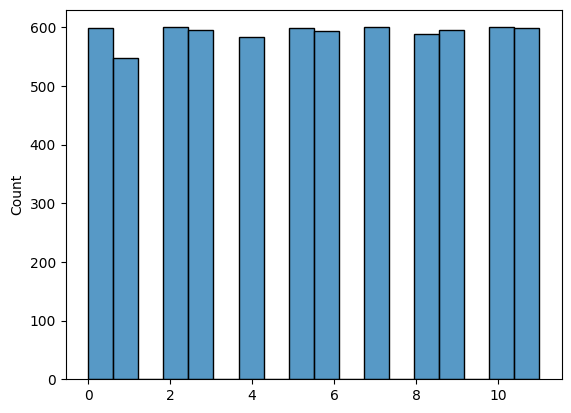

In [17]:
sns.histplot(x=y_data)